In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [39]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

In [ ]:
file_path = "../data/data_listrik_utara_clean.xlsx"
output_dir = "results_lstm_gru_callback2"
os.makedirs(output_dir, exist_ok=True)

data = pd.read_excel(file_path)

features = ['konsumsi_kWh_clean'] 
dataset = data[features].astype(float)

In [41]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

min_kwh = scaler.data_min_[0]
max_kwh = scaler.data_max_[0]

In [42]:
sequence_length = 12
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

dates = data['tanggal'].iloc[sequence_length:].reset_index(drop=True)

In [43]:
n = len(X)
train_size = int(n * 0.8)
val_size   = int(n * 0.1)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

train_main_dates = dates[:train_size]
val_dates = dates[train_size:train_size + val_size]
test_dates = dates[train_size + val_size:]

print("Pembagian Data Time Series (80/10/10)")
print(f"Total Sequence : {n}")
print(f"Train (80%)    : {len(X_train)}")
print(f"Val (10%)      : {len(X_val)}")
print(f"Test (10%)     : {len(X_test)}")

Pembagian Data Time Series (80/10/10)
Total Sequence : 56
Train (80%)    : 44
Val (10%)      : 5
Test (10%)     : 7


In [44]:
# invers target
y_train_inv = y_train * (max_kwh - min_kwh) + min_kwh
y_val_inv   = y_val   * (max_kwh - min_kwh) + min_kwh
y_test_inv  = y_test  * (max_kwh - min_kwh) + min_kwh

Training LSTM | Batch 32
>>> Best Model Saved : LSTM | Batch 32
>>> Best Epoch      : 302
>>> Val Loss        : 0.001758
>>> MAPE Test       : 8.59 %



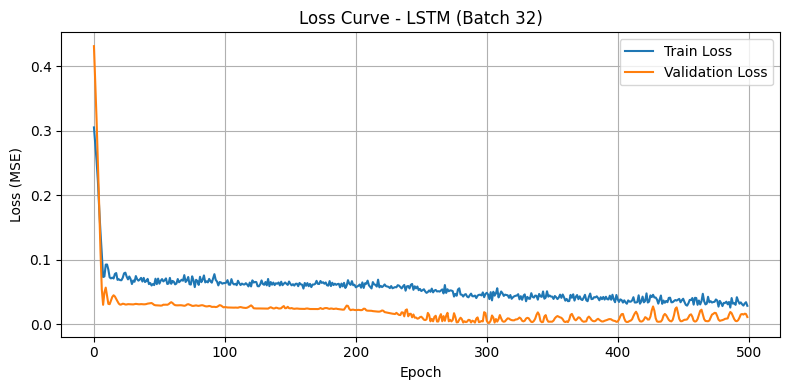

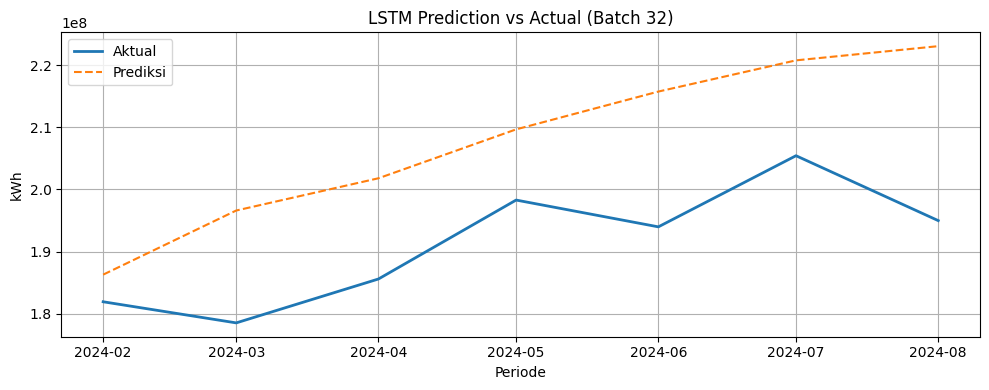

Training LSTM | Batch 64
>>> Best Model Saved : LSTM | Batch 64
>>> Best Epoch      : 292
>>> Val Loss        : 0.005265
>>> MAPE Test       : 12.36 %



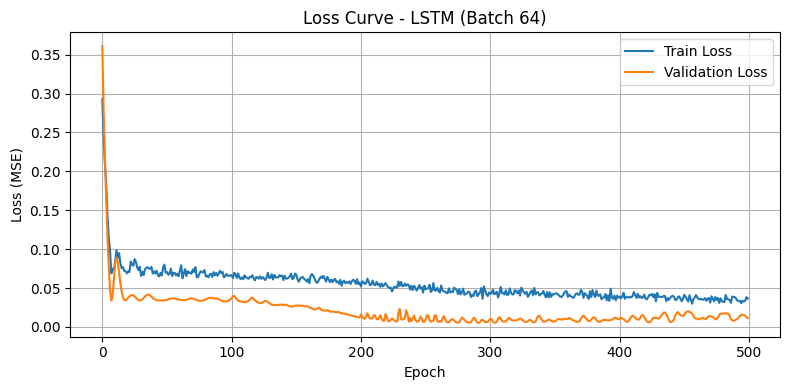

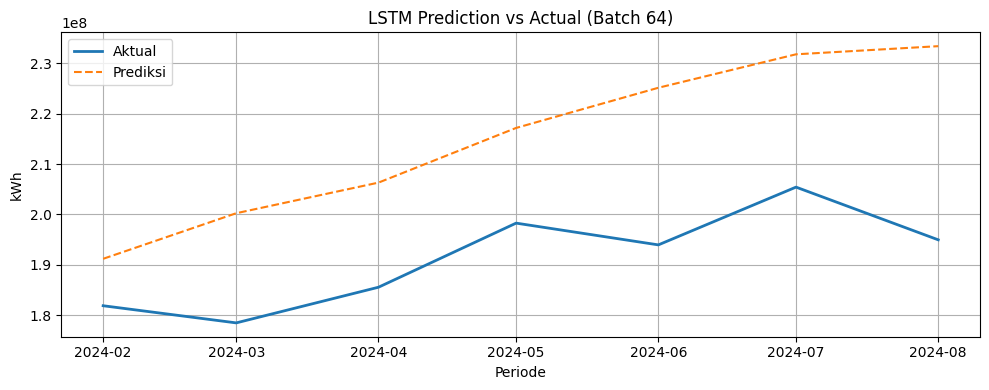

Training GRU | Batch 32
>>> Best Model Saved : GRU | Batch 32
>>> Best Epoch      : 223
>>> Val Loss        : 0.002867
>>> MAPE Test       : 6.39 %



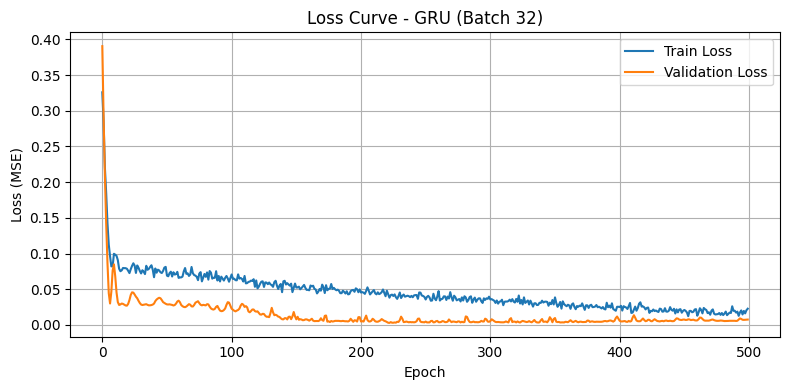

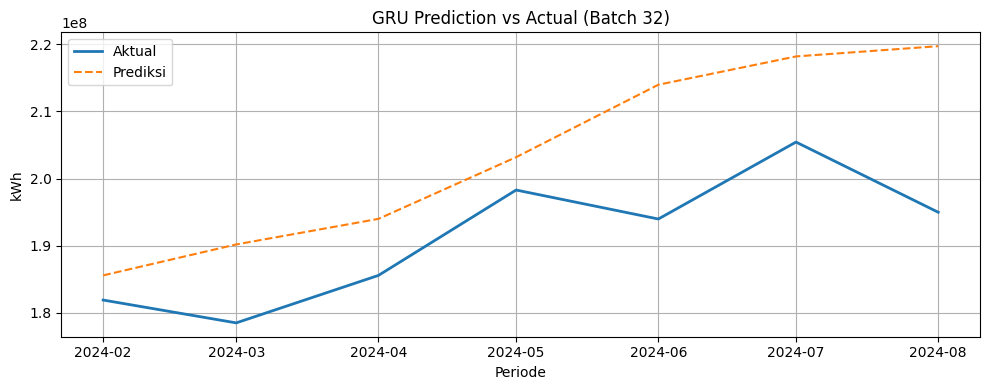

Training GRU | Batch 64
>>> Best Model Saved : GRU | Batch 64
>>> Best Epoch      : 389
>>> Val Loss        : 0.003168
>>> MAPE Test       : 10.78 %



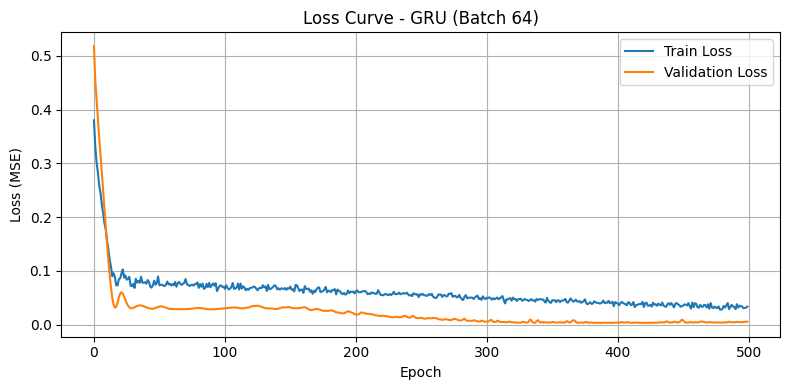

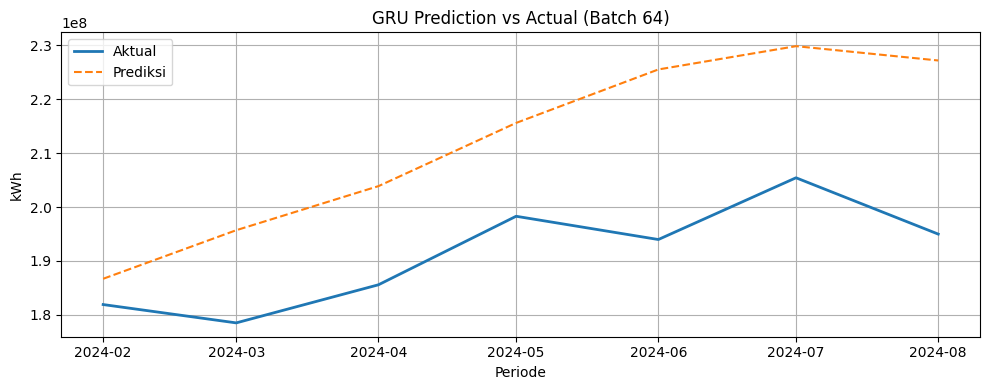


=== REKAP HASIL TRAINING ===
  Model  Batch  Best_Epoch   MAPE_Inv
0   GRU     32         223   6.391557
1  LSTM     32         302   8.587086
2   GRU     64         389  10.784063
3  LSTM     64         292  12.361506


In [45]:
models_to_train = ['LSTM', 'GRU']
batch_sizes = [32, 64]
MAX_EPOCHS = 500

results = []
all_histories = []

for model_type in models_to_train:
    for batch in batch_sizes:
        print("="*60)
        print(f"Training {model_type} | Batch {batch}")
        print("="*60)
        model = Sequential()

        if model_type == 'LSTM':
            model.add(LSTM(64, return_sequences=True,
                           input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(Dropout(0.2))
            model.add(LSTM(32))
        else:
            model.add(GRU(64, return_sequences=True,
                          input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(Dropout(0.2))
            model.add(GRU(32))

        model.add(Dropout(0.2))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # SIMPAN MODEL TERBAIK 
        checkpoint_path = os.path.join(
            output_dir,
            f"{model_type}_batch{batch}_best.h5"
        )

        checkpoint = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        )

        history = model.fit(
            X_train, y_train,
            epochs=MAX_EPOCHS,
            batch_size=batch,
            validation_data=(X_val, y_val),
            callbacks=[checkpoint],
            verbose=0
        )

        # LOAD MODEL TERBAIK
        best_model = load_model(checkpoint_path, compile=False)

        # EVALUASI TEST
        y_pred_scaled = best_model.predict(X_test, verbose=0).flatten()
        y_pred_inv = y_pred_scaled * (max_kwh - min_kwh) + min_kwh

        mape_inv = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
        best_epoch = np.argmin(history.history['val_loss']) + 1
        best_val_loss = np.min(history.history['val_loss'])

        print(f">>> Best Model Saved : {model_type} | Batch {batch}")
        print(f">>> Best Epoch      : {best_epoch}")
        print(f">>> Val Loss        : {best_val_loss:.6f}")
        print(f">>> MAPE Test       : {mape_inv:.2f} %\n")

        # SIMPAN REKAP
        results.append({
            "Model": model_type,
            "Batch": batch,
            "Best_Epoch": best_epoch,
            "MAPE_Inv": mape_inv
        })

        all_histories.append({
            "model": model_type,
            "batch": batch,
            "loss": history.history['loss'],
            "val_loss": history.history['val_loss']
        })

        # VISUALISASI LOSS
        plt.figure(figsize=(8, 4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Loss Curve - {model_type} (Batch {batch})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # VISUALISASI PREDIKSI 
        plt.figure(figsize=(10, 4))
        plt.plot(test_dates, y_test_inv, label='Aktual', linewidth=2)
        plt.plot(test_dates, y_pred_inv, '--', label='Prediksi')
        plt.title(f'{model_type} Prediction vs Actual (Batch {batch})')
        plt.xlabel('Periode')
        plt.ylabel('kWh')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
# REKAP HASIL AKHIR
results_df = pd.DataFrame(results).sort_values("MAPE_Inv").reset_index(drop=True)

print("\n=== REKAP HASIL TRAINING ===")
print(results_df)

In [46]:
results_df = pd.DataFrame(results).sort_values("MAPE_Inv").reset_index(drop=True)
results_df.to_csv(os.path.join(output_dir, "rekap_hasil_model.csv"), index=False)

print("=== REKAP HASIL ===")
print(results_df)

=== REKAP HASIL ===
  Model  Batch  Best_Epoch   MAPE_Inv
0   GRU     32         223   6.391557
1  LSTM     32         302   8.587086
2   GRU     64         389  10.784063
3  LSTM     64         292  12.361506


In [47]:
# MODEL TERBAIK (BERDASARKAN MAPE TERKECIL)
results_df = results_df.sort_values("MAPE_Inv").reset_index(drop=True)

best_row = results_df.iloc[0]

best_model_type = best_row['Model']
best_batch = int(best_row['Batch'])
best_epoch = int(best_row['Best_Epoch'])
best_mape = best_row['MAPE_Inv']

print("=== MODEL TERBAIK (BERDASARKAN MAPE) ===")
print(f"Model        : {best_model_type}")
print(f"Batch Size   : {best_batch}")
print(f"Epoch Terbaik: {best_epoch}")
print(f"MAPE Test    : {best_mape:.2f}%")

=== MODEL TERBAIK (BERDASARKAN MAPE) ===
Model        : GRU
Batch Size   : 32
Epoch Terbaik: 223
MAPE Test    : 6.39%


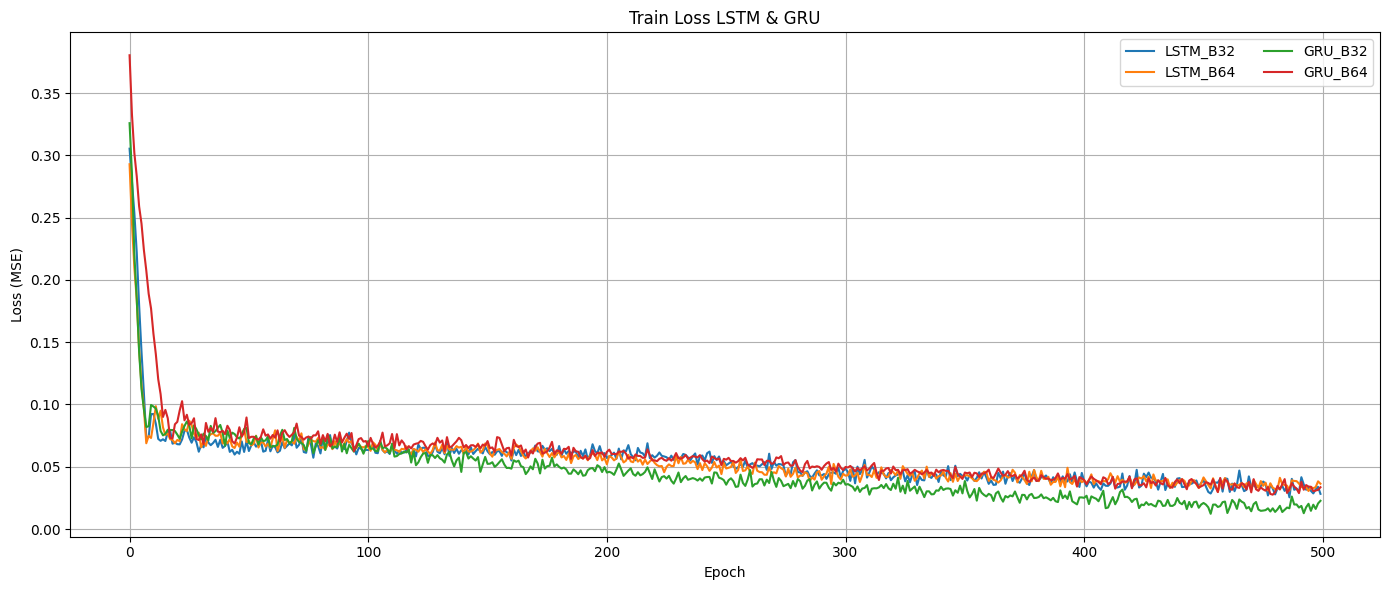

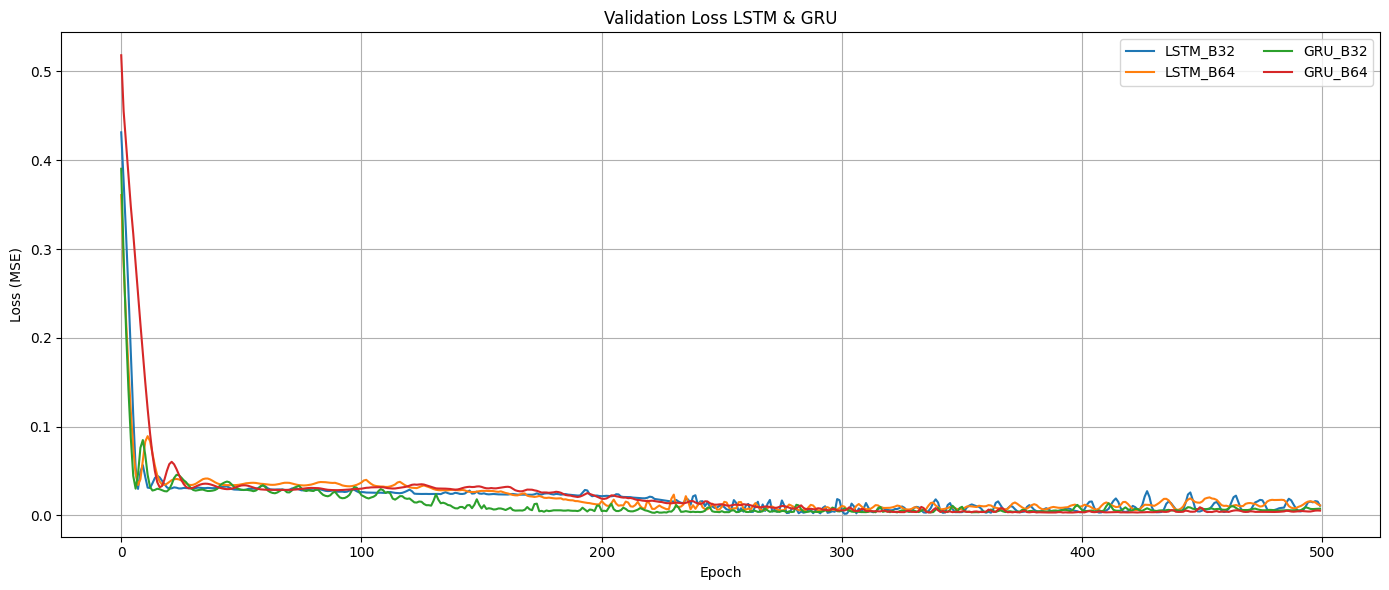

In [48]:
# train loss
plt.figure(figsize=(14, 6))
for h in all_histories:
    style = '-' if h['model'] == 'LSTM' else '-'
    plt.plot(h['loss'], linestyle=style,
             label=f"{h['model']}_B{h['batch']}")
plt.title("Train Loss LSTM & GRU")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# val loss
plt.figure(figsize=(14, 6))
for h in all_histories:
    style = '-' if h['model'] == 'LSTM' else '-'
    plt.plot(h['val_loss'], linestyle=style, label=f"{h['model']}_B{h['batch']}")
plt.title("Validation Loss LSTM & GRU")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


=== MODEL TERBAIK  ===
Model      : GRU
Batch Size : 32
Epoch      : 223
MAPE Test  : 6.39%


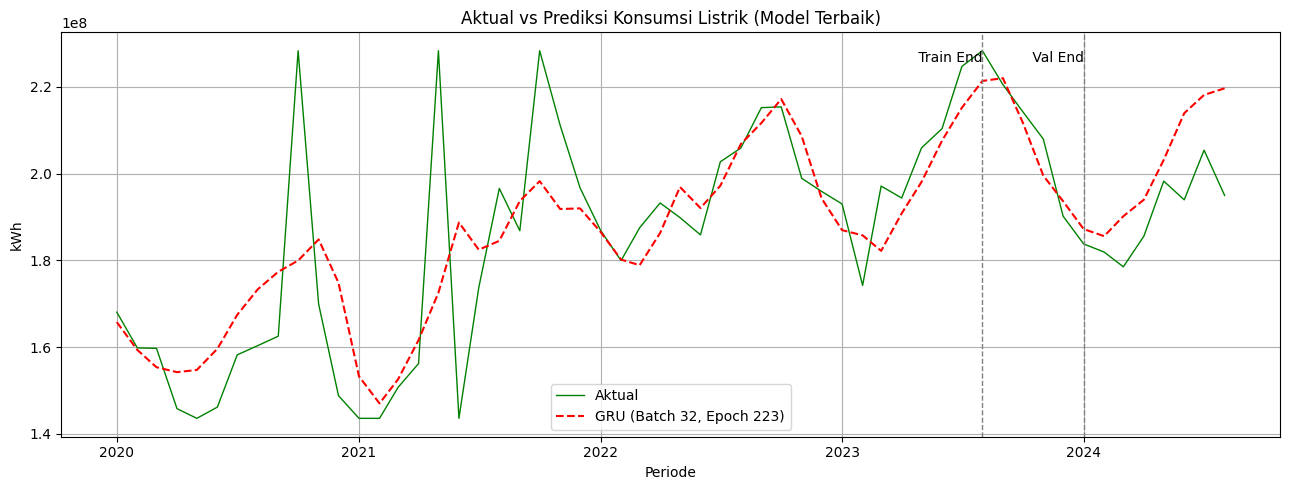

File prediksi model terbaik berhasil disimpan:
results_lstm_gru_callback2\prediksi_model_terbaik.csv


In [49]:
# PILIH MODEL TERBAIK  (MAPE TERKECIL)
best_row = results_df.sort_values("MAPE_Inv").iloc[0]

best_model_type = best_row['Model']
best_batch = int(best_row['Batch'])
best_epoch = int(best_row['Best_Epoch'])
best_mape = best_row['MAPE_Inv']

best_model_path = os.path.join(
    output_dir,
    f"{best_model_type}_batch{best_batch}_best.h5"
)

best_model = load_model(best_model_path, compile=False)

print("=== MODEL TERBAIK  ===")
print(f"Model      : {best_model_type}")
print(f"Batch Size : {best_batch}")
print(f"Epoch      : {best_epoch}")
print(f"MAPE Test  : {best_mape:.2f}%")

# DATA GABUNGAN
X_all = np.concatenate([X_train, X_val, X_test])

all_dates = pd.concat(
    [train_main_dates, val_dates, test_dates]
).reset_index(drop=True)

all_true = np.concatenate(
    [y_train_inv, y_val_inv, y_test_inv]
)

# PREDIKSI MODEL TERBAIK
pred_scaled = best_model.predict(X_all, verbose=0).flatten()
pred_inv = pred_scaled * (max_kwh - min_kwh) + min_kwh

# VISUALISASI AKTUAL vs PREDIKSI (MODEL TERBAIK)
train_end = train_main_dates.iloc[-1]
val_end   = val_dates.iloc[-1]

plt.figure(figsize=(13, 5))
plt.plot(all_dates, all_true,
         label="Aktual", color="green", linewidth=1)
plt.plot(all_dates, pred_inv,
         linestyle="--", color="red",
         label=f"{best_model_type} (Batch {best_batch}, Epoch {best_epoch})")
plt.axvline(train_end, linestyle='--', color='grey', linewidth=1)
plt.text(train_end, max(all_true), " Train End", ha='right', va='top')
plt.axvline(val_end, linestyle='--', color='grey', linewidth=1)
plt.text(val_end, max(all_true), " Val End", ha='right', va='top')
plt.title("Aktual vs Prediksi Konsumsi Listrik (Model Terbaik)")
plt.xlabel("Periode")
plt.ylabel("kWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# SIMPAN HASIL PREDIKSI
df_best = pd.DataFrame({
    "Tanggal": all_dates,
    "Aktual_kWh": all_true,
    "Prediksi_kWh": pred_inv
})

output_path = os.path.join(
    output_dir,
    "prediksi_model_terbaik.csv"
)

df_best.to_csv(output_path, index=False)

print("File prediksi model terbaik berhasil disimpan:")
print(output_path)

=== MODEL TERBAIK ===
LSTM | Batch 32 | Epoch 302 | MAPE 8.59%
GRU  | Batch 32  | Epoch 223  | MAPE 6.39%


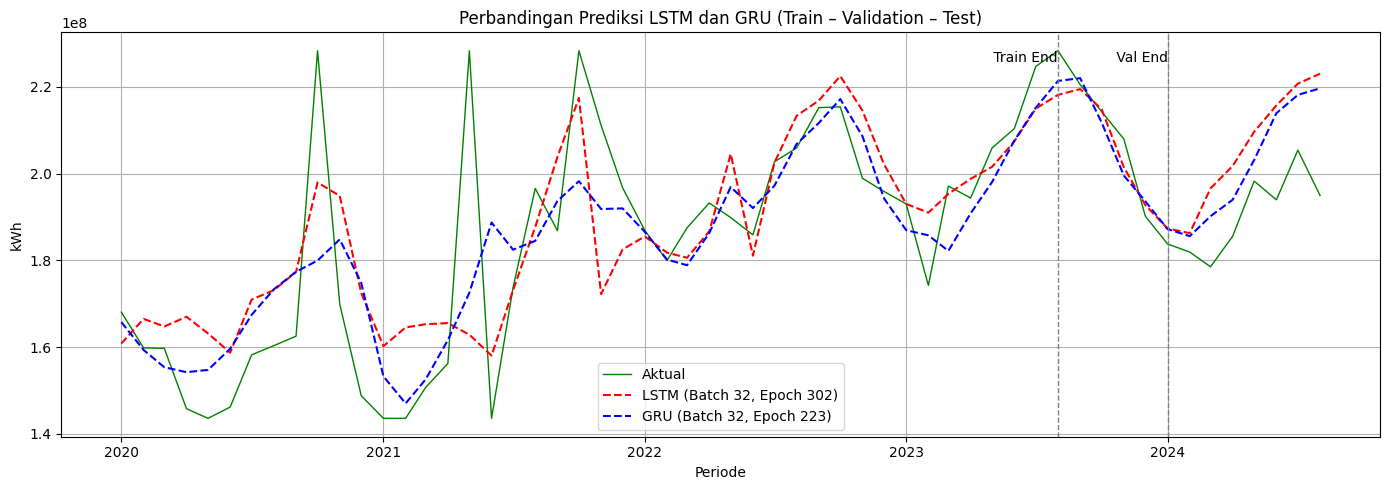

File perbandingan LSTM & GRU berhasil disimpan:
results_lstm_gru_callback2\prediksi_perbandingan_LSTM_GRU_terbaik.csv


In [50]:
# AMBIL MODEL LSTM & GRU TERBAIK
best_lstm = results_df[results_df['Model'] == 'LSTM'].iloc[0]
best_gru  = results_df[results_df['Model'] == 'GRU'].iloc[0]

lstm_batch = int(best_lstm['Batch'])
gru_batch  = int(best_gru['Batch'])

lstm_epoch = int(best_lstm['Best_Epoch'])
gru_epoch  = int(best_gru['Best_Epoch'])

lstm_mape = best_lstm['MAPE_Inv']
gru_mape  = best_gru['MAPE_Inv']

lstm_path = os.path.join(output_dir, f"LSTM_batch{lstm_batch}_best.h5")
gru_path  = os.path.join(output_dir, f"GRU_batch{gru_batch}_best.h5")

lstm_model = load_model(lstm_path, compile=False)
gru_model  = load_model(gru_path, compile=False)

print("=== MODEL TERBAIK ===")
print(f"LSTM | Batch {lstm_batch} | Epoch {lstm_epoch} | MAPE {lstm_mape:.2f}%")
print(f"GRU  | Batch {gru_batch}  | Epoch {gru_epoch}  | MAPE {gru_mape:.2f}%")

# DATA GABUNGAN
X_all = np.concatenate([X_train, X_val, X_test])
all_dates = pd.concat(
    [train_main_dates, val_dates, test_dates]
).reset_index(drop=True)

all_true = np.concatenate(
    [y_train_inv, y_val_inv, y_test_inv]
)

# PREDIKSI LSTM & GRU
pred_lstm_scaled = lstm_model.predict(X_all, verbose=0).flatten()
pred_gru_scaled  = gru_model.predict(X_all, verbose=0).flatten()

pred_lstm = pred_lstm_scaled * (max_kwh - min_kwh) + min_kwh
pred_gru  = pred_gru_scaled  * (max_kwh - min_kwh) + min_kwh

# VISUALISASI PERBANDINGAN LSTM vs GRU
train_end = train_main_dates.iloc[-1]
val_end   = val_dates.iloc[-1]

plt.figure(figsize=(14, 5))
plt.plot(all_dates, all_true,
         label="Aktual", color="green", linewidth=1)
plt.plot(all_dates, pred_lstm,
         linestyle="--", color="red",
         label=f"LSTM (Batch {lstm_batch}, Epoch {lstm_epoch})")
plt.plot(all_dates, pred_gru,
         linestyle="--", color="blue",
         label=f"GRU (Batch {gru_batch}, Epoch {gru_epoch})")
plt.axvline(train_end, linestyle='--', color='grey', linewidth=1)
plt.text(train_end, max(all_true), " Train End", ha='right', va='top')
plt.axvline(val_end, linestyle='--', color='grey', linewidth=1)
plt.text(val_end, max(all_true), " Val End", ha='right', va='top')
plt.title("Perbandingan Prediksi LSTM dan GRU (Train – Validation – Test)")
plt.xlabel("Periode")
plt.ylabel("kWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# SIMPAN HASIL PERBANDINGAN
df_compare = pd.DataFrame({
    "Tanggal": all_dates,
    "Aktual_kWh": all_true,
    "Pred_LSTM_kWh": pred_lstm,
    "Pred_GRU_kWh": pred_gru
})

output_path = os.path.join(
    output_dir,
    "prediksi_perbandingan_LSTM_GRU_terbaik.csv"
)

df_compare.to_csv(output_path, index=False)
print("File perbandingan LSTM & GRU berhasil disimpan:")
print(output_path)